In [1]:
library("osmdata")
library("rstac")
library("terra")

Data (c) OpenStreetMap contributors, ODbL 1.0. https://www.openstreetmap.org/copyright

Warning message:
“il pacchetto ‘rstac’ è stato creato con R versione 4.3.2”
Warning message:
“il pacchetto ‘terra’ è stato creato con R versione 4.3.2”
terra 1.7.71



# Search and download Copernicus DEM data for Bucharest

We use OSM data to define our area of interest (AoI): 

In [2]:
bb <- getbb("Bucharest")
bb

,min,max
x,25.96667,26.22558
y,44.33425,44.54140


The Earth Search STAC catalog lists few open datasets on AWS, including the Copernicus DEM GLO-30 (global, 30m resolution). We query the calalog for the DEM tiles intersecting our AoI:

In [3]:
s_obj <- stac("https://earth-search.aws.element84.com/v1")

it_obj <- s_obj |>
  stac_search(collections = "cop-dem-glo-30",
              bbox = as.vector(bb),
              limit = 100) |> 
  get_request()

We extract the links to the assets - the actual data files:

In [4]:
asset_urls <- rstac::assets_url(it_obj)
asset_urls

[1] "s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N44_00_E026_00_DEM/Copernicus_DSM_COG_10_N44_00_E026_00_DEM.tif"
[2] "s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N44_00_E025_00_DEM/Copernicus_DSM_COG_10_N44_00_E025_00_DEM.tif"

Note that the files are openly accessible, but the links are provided as AWS S3 bucket URLs. These can be read directly by GDAL/Terra, but a AWS account needs to be created and [credentials needs to be stored in a configuration file](https://docs.aws.amazon.com/keyspaces/latest/devguide/access.credentials.html). 

We now load the raster files, crop them using our AoI, create a mosaic from the tiles and plot the output:

In [5]:
dem <- asset_urls |>
    lapply(rast) |> 
    lapply(crop, as.vector(t(bb))) |>
    do.call(merge, args=_)

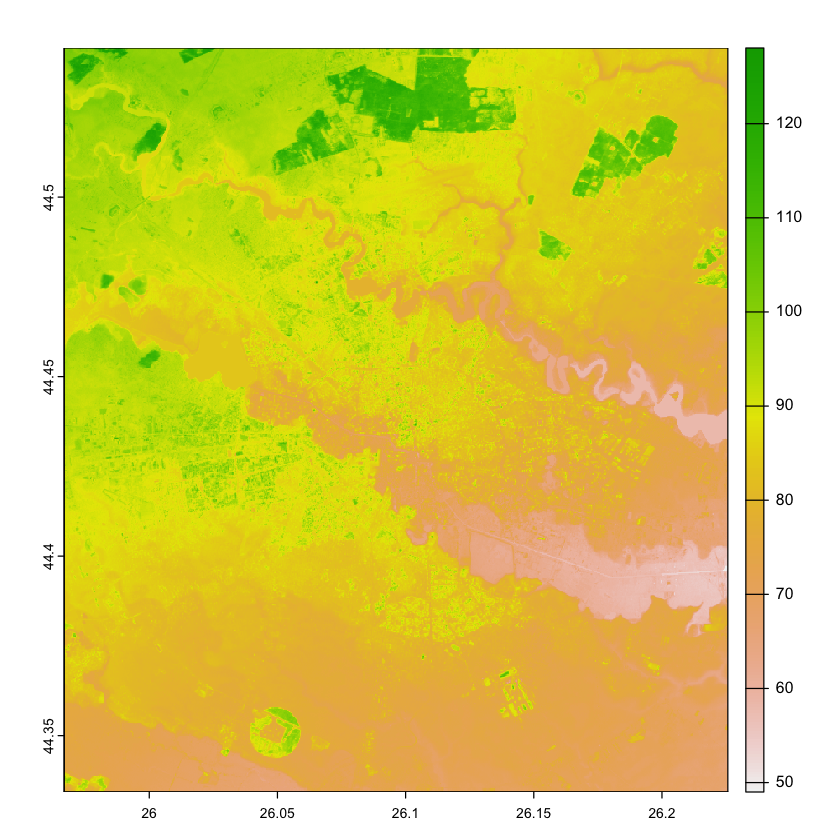

In [6]:
plot(dem)

Finally, we store the output in a (cloud-optimized) GeoTiff (COG) file:

In [7]:
writeRaster(
    x=dem,
    filename="../data/DEM_Bucharest.tif",
    filetype="COG",
)